In [ ]:
#install dependencies
!pip install tensorflow pandas matplotlib scikit-learn

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
#preprocess

from tensorflow.keras.layers import TextVectorization

In [ ]:
#comment itself
X = df['comment_text']
#features
y = df[df.columns[2:]].values

#num words in vocab
MAX_FEATURES = 200000


In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)

In [ ]:
vectorizer('Hello world, how are you')[:5] #vectorized this sentence

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,  73,  20,   7])>

In [ ]:
#now we do for whole dataset
vectorized_text = vectorizer(X.values)

In [ ]:
#make tf dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
dataset.as_numpy_iterator().next()

(array([[  616,   151,    12, ...,     0,     0,     0],
        [  171,   171,    41, ...,     0,     0,     0],
        [    8,    69,    10, ...,     0,     0,     0],
        ...,
        [  345,     1,    56, ...,     0,     0,     0],
        [   38, 14474,     2, ...,     0,     0,     0],
        [   14,   661,     9, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [ ]:
print(len(dataset))

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

print(len(train))
print(len(val))
print(len(test))

9974
6981
1994
997


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding



In [28]:
model = Sequential()
#create embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
#Bidirection LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
#final layer
model.add(Dense(6, activation='sigmoid'))

In [29]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [30]:
model.build(input_shape=(None, 1800))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 690s 98ms/step - loss: 0.0919 - val_loss: 0.0482
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 687s 98ms/step - loss: 0.0495 - val_loss: 0.0404
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 687s 98ms/step - loss: 0.0439 - val_loss: 0.0378
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 687s 98ms/step - loss: 0.0390 - val_loss: 0.0378
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 687s 98ms/step - loss: 0.0377 - val_loss: 0.0334


<Figure size 800x500 with 0 Axes>

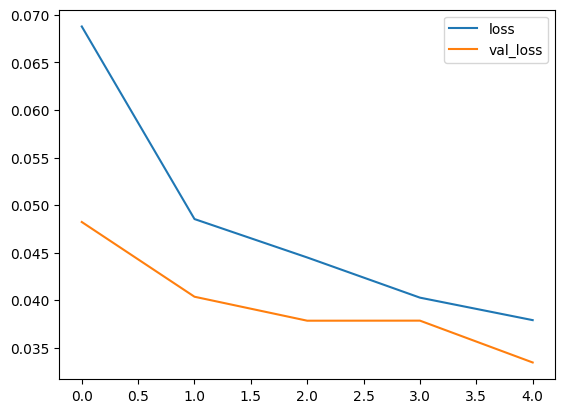

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [33]:
#now lets make predictions
input_text = vectorizer('You freaking suck!')
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


In [34]:
print(res)

[[0.9960582  0.0983758  0.94059795 0.02067149 0.79326594 0.11762066]]


In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    #unpack the batch
    X_true, y_true = batch
    #make a prediction
    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━

In [37]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8723196983337402, Recall: 0.7636518478393555, Accuracy: 0.48946839570999146


In [38]:
model.save('toxicity.h5')